# System settings and packages

In [2]:
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import random
import numpy as np
import pandas as pd
import os
# import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
import matplotlib.image as mpimg

from os import listdir
from os.path import isfile, join
import re

from PIL import Image
import glob

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Specifying paths

In [3]:
# Where to save the figures

PROJECT_ROOT_DIR = "output"
CHAPTER_ID = "Classification"
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Checking out the data

In [4]:
datapath = os.path.join("input", "sample_segmented_images", "")

In [5]:
train_df = pd.read_csv(datapath + "seg_train_sample_100.csv", sep = ';')

In [6]:
train_df.head(10)

,image,species,individual_id
0,0a572d02a1ed8e.png,minke_whale,0940fc2c3809
1,0a0ae8699f1a5a.png,beluga,af02c0601c6e
2,0a0cedc8ac6499.png,melon_headed_whale,fa870e1ae82d
3,0a0d83708b4fdc.png,bottlenose_dolphin,c2705f9e75c8
4,0a0e4b82b9f3ee.png,humpback_whale,02f5c5ee9c2a
5,0a0e90fb154acf.png,false_killer_whale,f7bb4f9a9d1a
6,0a0f53c069bffc.png,spinner_dolphin,1b9d07e72110
7,0a01b620a7915b.png,blue_whale,7c9f2b782eed
8,0a1bcf1da2b695.png,beluga,d53bc5d9dbfe
9,0a1c741127059b.png,bottlenose_dolphin,a43daee90cbc


In [7]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           17
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
false_killer_whale            4
kiler_whale                   3
melon_headed_whale            3
bottlenose_dolpin             2
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
short_finned_pilot_whale      2
fin_whale                     2
pantropic_spotted_dolphin     1
killer_whale                  1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pilot_whale                   1
pygmy_killer_whale            1
Name: species, dtype: int64

We have some typos in the species:

E.g., there is bottlenose_dolphin and bottlenose_dolpin, kiler_whale and killer_whale. Obviously, it is typos. Also, globis and pilot_whale are short_finned_pilot_whale

We thus need to correct the labels:


In [8]:
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [9]:
train_df['species']. value_counts()

beluga                       20
bottlenose_dolphin           19
humpback_whale               16
blue_whale                    7
spinner_dolphin               6
minke_whale                   4
killer_whale                  4
false_killer_whale            4
melon_headed_whale            3
short_finned_pilot_whale      3
long_finned_pilot_whale       2
common_dolphin                2
dusky_dolphin                 2
fin_whale                     2
pantropic_spotted_dolphin     1
cuviers_beaked_whale          1
southern_right_whale          1
gray_whale                    1
spotted_dolphin               1
pygmy_killer_whale            1
Name: species, dtype: int64

In [10]:
y = train_df["species"]

In [11]:
y.shape

(100,)

In [12]:
train_df['individual_id']. value_counts()

4a67e64bd3b7    2
0940fc2c3809    1
7bedeacdc4d2    1
26c9084d9e34    1
6025575fb0cf    1
               ..
31f748b822f4    1
be3742892267    1
650f189103b8    1
54c26574e46b    1
02da0e68dccd    1
Name: individual_id, Length: 99, dtype: int64

# Loading the Images

Define path to data

In [28]:
ROOT_PATH_DATA = "input/"
PATH_DATA_TRAIN_SAMPLE = os.path.join(ROOT_PATH_DATA + "sample_segmented_images/seg_train_sample_100")

PATH_DATA_TRAIN_SAMPLE

'input/sample_segmented_images/seg_train_sample_100'

In [29]:
# Defining function to list all pictures to include
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [30]:
filepaths_train_sample = list_files(PATH_DATA_TRAIN_SAMPLE)

In [31]:
### i don't know if we gonna need that
# Extract pic ids from files in consideration
#Correct pic ids
pic_ids_train_sample = np.array([])
for i in range(len(filepaths_train_sample)):
    file_short = filepaths_train_sample[i].replace(PATH_DATA_TRAIN_SAMPLE + "/", "SAMPLE/")
    pic_ids_train_sample = np.append(pic_ids_train_sample, file_short)

In [32]:
pic_ids_train_sample

array(['SAMPLE/0a100ed55f1c7e.png', 'SAMPLE/0a0cedc8ac6499.png',
       'SAMPLE/0a9f092e4e3e92.png', 'SAMPLE/0a07fcc5ab1b4d.png',
       'SAMPLE/0a3f7ed710605e.png', 'SAMPLE/0a1bcf1da2b695.png',
       'SAMPLE/0a4ef0609c5bb9.png', 'SAMPLE/0a99ad33a87739.png',
       'SAMPLE/0a23cedc1e719e.png', 'SAMPLE/0a39e7972b191c.png',
       'SAMPLE/0a93b0a0d4f3a7.png', 'SAMPLE/0a97d1e6751b0d.png',
       'SAMPLE/0a7dd6215c0916.png', 'SAMPLE/0a6da6533bd494.png',
       'SAMPLE/0a5f343d8435ce.png', 'SAMPLE/0a164ed77a3ed3.png',
       'SAMPLE/0a6bfeed7be2f4.png', 'SAMPLE/0a0802b2d2d759.png',
       'SAMPLE/0a53d2f897157c.png', 'SAMPLE/0a6a52264469b6.png',
       'SAMPLE/0a83ebfa98e751.png', 'SAMPLE/0a99cbb091b9b8.png',
       'SAMPLE/0a32fb56190d7c.png', 'SAMPLE/0a2d7ead9bec6c.png',
       'SAMPLE/0a40dccc6d5a6a.png', 'SAMPLE/0a380a45691ce5.png',
       'SAMPLE/0a312f2d4a679d.png', 'SAMPLE/0a14b0bc5bb868.png',
       'SAMPLE/0a3e6fa90daced.png', 'SAMPLE/0a550a7d4633b4.png',
       'SAMPLE/0a01b620a7

In [33]:
image_list = []
for filename in glob.glob(os.path.join(PATH_DATA_TRAIN_SAMPLE +'/*.png')):
    im=Image.open(filename)
    image_list.append(im)

Saving figure sample_image_plot


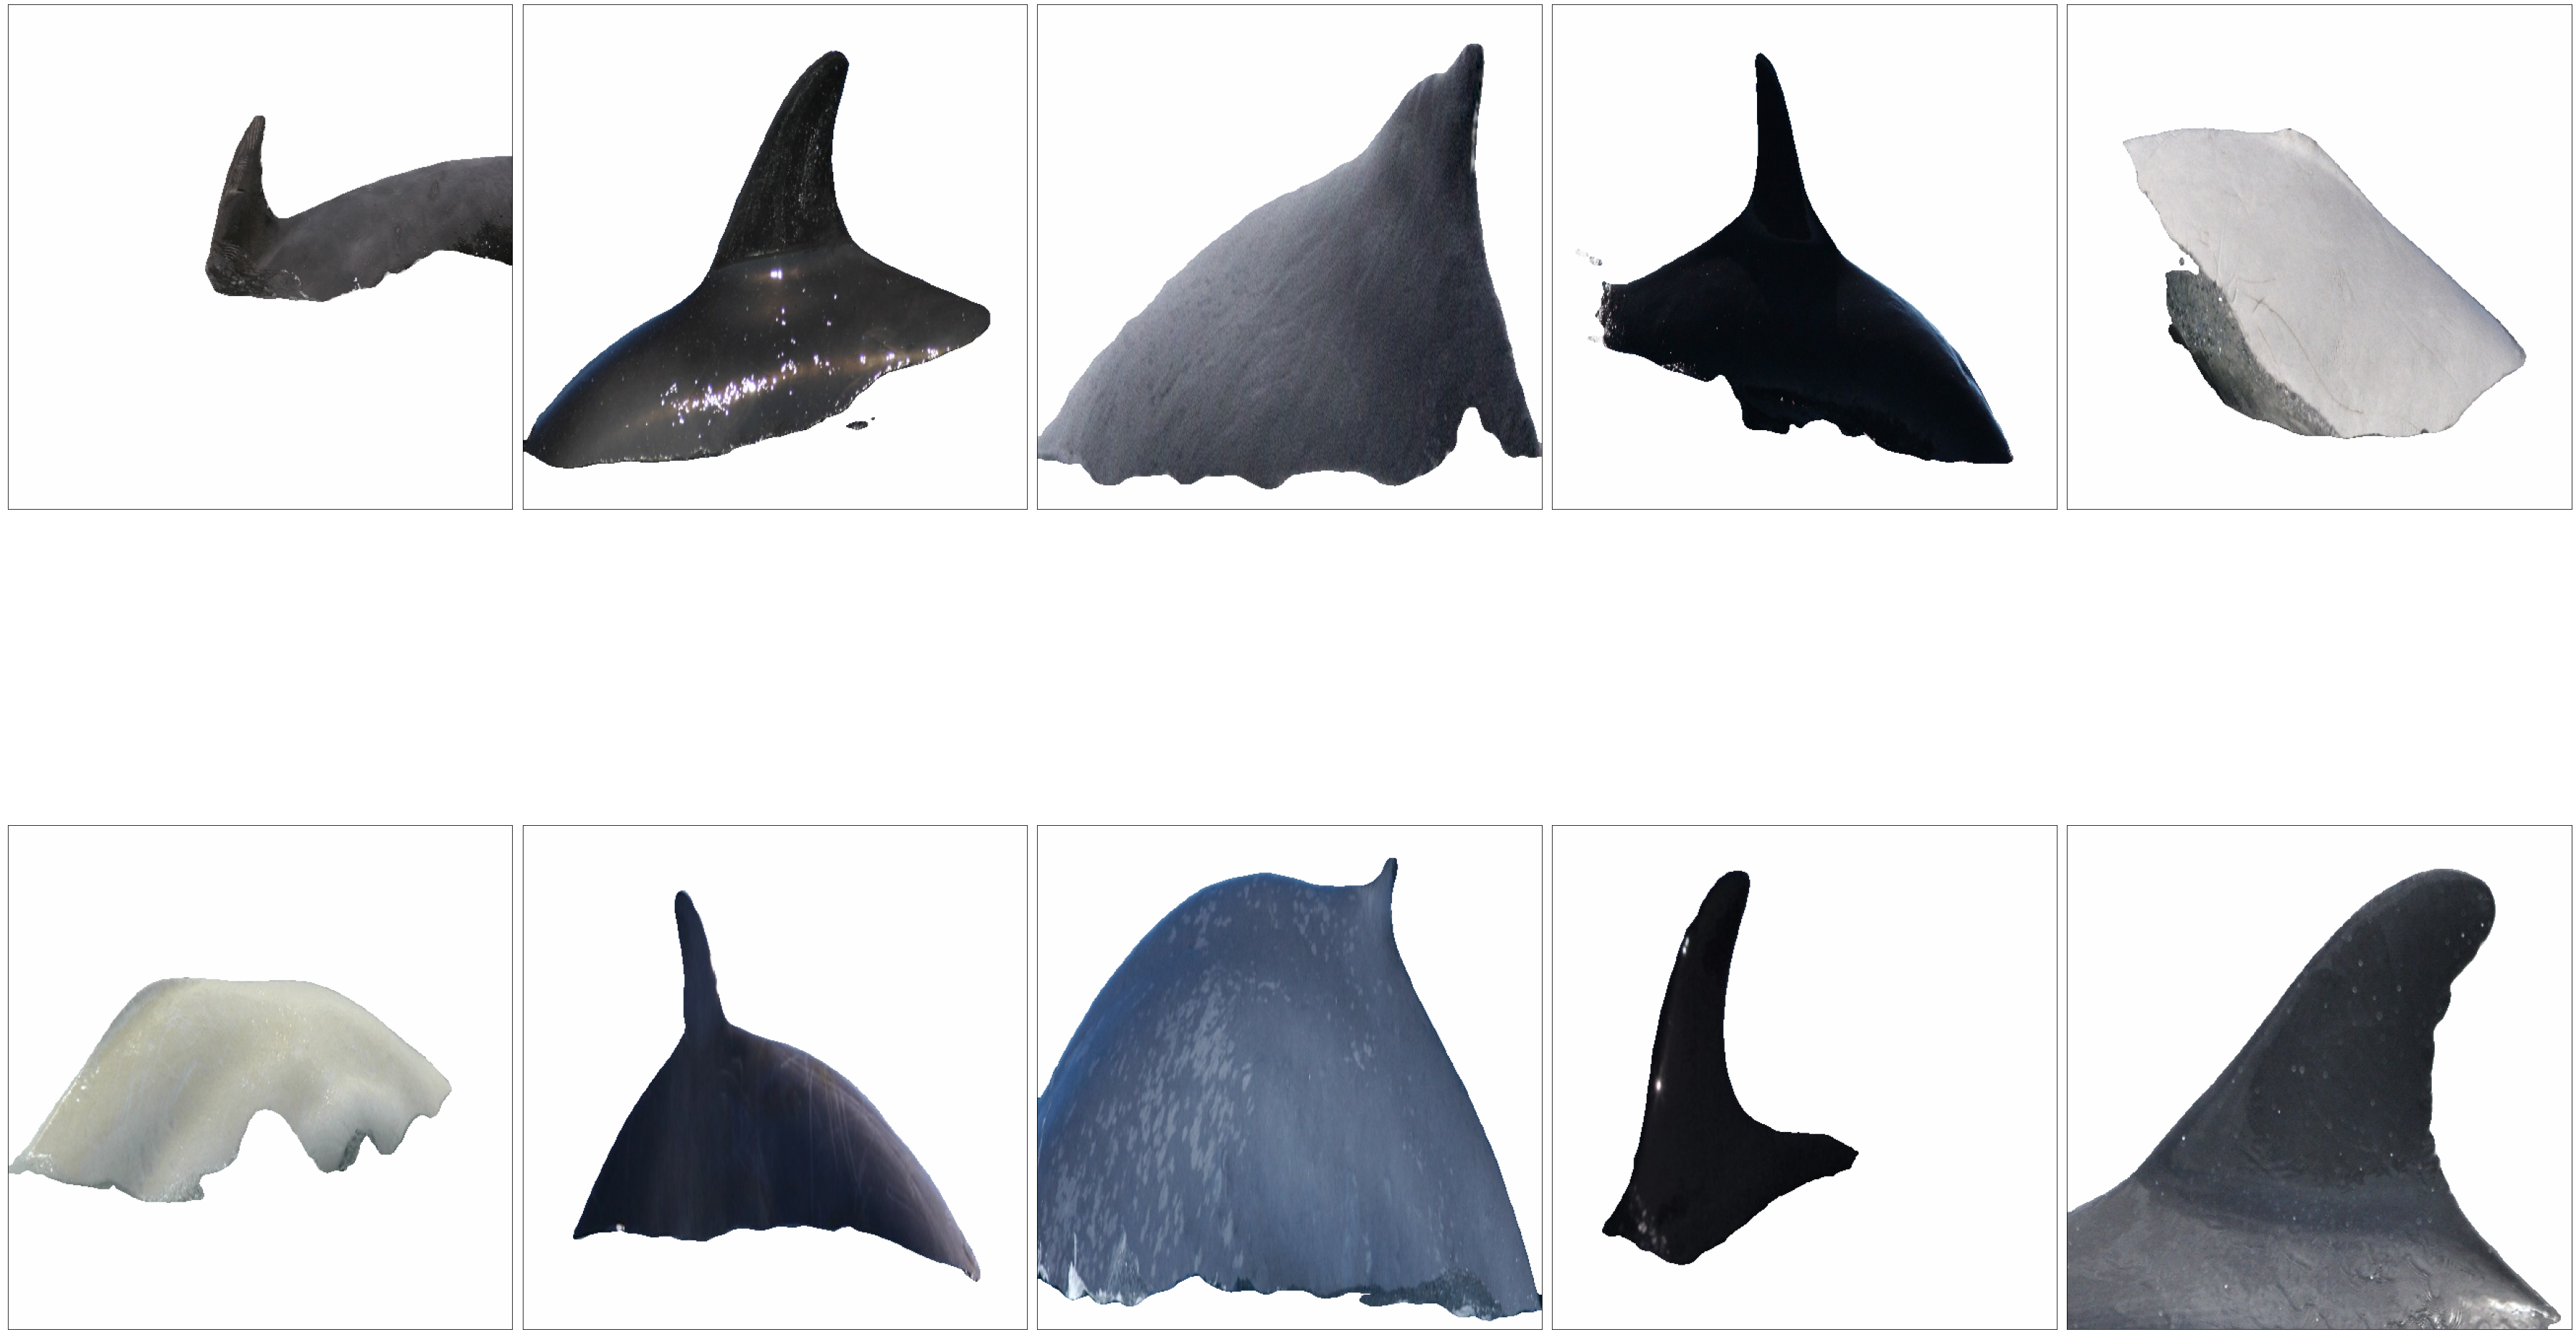

In [34]:
example_images = image_list[:10]
plt.figure(figsize=(50,50))
columns = 5
for i, image in enumerate(example_images):
    plt.subplot(int(len(example_images) / columns + 1), columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
save_fig("sample_image_plot")
plt.show()

# Function to transform images into np.array

In [35]:
# Importing necessary libraries/functions
from PIL import Image as PIL_Image
import timeit


# Defining function that performs translation of jpg files into numerical representation
def pixel_transformation(target_pixel):   
           
        # Run-time information
        start_time = timeit.default_timer()
        print(">... Starting pixel transformation for correct pictures for resolution: ", target_pixel, "x", target_pixel)

        # Initialize emtpy array of fitting length
        array_length = target_pixel*target_pixel*3 #Times 3 as we have 3 values (RGB) per pixel
        loaded_pics_train_sample = np.empty([0,array_length])

        #Running trough all correctly worn image files
        for filename in filepaths_train_sample:
            # open picture
            pic = PIL_Image.open(filename)
            # Reduce size from original format to target format
            pic_resized = pic.resize((target_pixel, target_pixel))
            # Extract RGB data
            pic_data = np.array(pic_resized)
            # Include help array to reshape 3D-array(e.g.: 1024, 1024, 3) into 1D array
            help_array = np.reshape(pic_data,(pic_data.size,))
            # Stack each array onto each other to have one larger array of shape (#obs,#pixels*3)
            loaded_pics_train_sample = np.vstack((loaded_pics_train_sample, help_array))
        
        #End run-time information
        elapsed = timeit.default_timer() - start_time
        print("Finished", target_pixel, "x", target_pixel ,"pixel transformation for correct pictures. Run-time in seconds: ", round(elapsed,2))
 
        # Returning
        return loaded_pics_train_sample # array with dimension pixels x pixels x colors for each image

In [36]:
pictures_numerical = pixel_transformation(224) # We choose a resolution of 224x224 pixels for the images

>... Starting pixel transformation for correct pictures for resolution:  224 x 224
Finished 224 x 224 pixel transformation for correct pictures. Run-time in seconds:  7.62


In [37]:
# Number of features of one picture:
len(pictures_numerical)
len(pictures_numerical[40])

150528

# Classification

# First: Logistic Multivariate Regression

In [38]:
from sklearn.linear_model import LogisticRegression

pictures_numerical_subset_10 = pictures_numerical[:10]

len(pictures_numerical_subset_10)

y_subset_10 = y[:10]

X, y = pictures_numerical_subset_10, y_subset_10

clf = LogisticRegression(random_state=0).fit(X,y)

In [39]:
clf.predict(X[:2, :])

array(['minke_whale', 'beluga'], dtype=object)

In [40]:
clf.predict_proba(X[:2, :])

array([[4.58561990e-24, 4.13263877e-21, 7.77439845e-26, 4.36133484e-09,
        2.44268986e-12, 7.32568006e-20, 9.99999996e-01, 5.94878164e-20],
       [9.99999999e-01, 1.64965309e-12, 1.52504456e-10, 7.04781145e-15,
        5.86507044e-10, 6.44872072e-13, 3.25274608e-16, 2.44454080e-10]])

In [41]:
clf.score(X, y)

1.0

In [42]:
clf.decision_function(X)


array([[-17.1381039 , -10.33435779, -21.21536329,  17.35052537,
          9.86309176,  -7.45930283,  36.60101303,  -7.66750239],
       [ 23.68009488,  -3.45036122,   1.07626758,  -8.90596438,
          2.42325844,  -4.38962956, -11.98176702,   1.54810124],
       [-15.5937136 ,  -2.83554165,  -1.13477829,  -8.92227696,
          1.8435793 ,  36.54980076,  -7.48940474,  -2.41766485],
       [-18.96362319,  -6.32330589,  44.43703953,  -9.57741246,
          3.83938865, -11.4012849 , -20.0424619 ,  18.03166014],
       [ -3.98498064,  -5.86524089, -12.14508876,   7.54600392,
         22.26434835, -10.25360064,   0.56763268,   1.87092594],
       [ -5.96184214,  -4.6417466 , -16.82641172,  24.5868963 ,
         10.00229844, -12.78116854,   6.45860823,  -0.83663401],
       [ -0.62804553,  -9.48210488,  10.29973875,  -6.98165221,
          4.77125451, -11.62104906, -19.23068042,  32.8725388 ],
       [ -4.4078461 ,  31.94720469,  -5.15288991,  -1.26413012,
         -0.07289767,  -4.8148552